In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import warnings
import pandas as pd
from astropy.wcs import WCS
warnings.filterwarnings("ignore")
from numpy.fft import rfft2, irfft2, ifftshift
from scipy.signal import fftconvolve
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from astropy.nddata import Cutout2D
import gc
from astropy.wcs.utils import proj_plane_pixel_scales
import astropy.units as u
import os
from multiprocessing import get_context
from src.filter_worker import process_rubin_filter, process_euclid_filter
from src.gaap_analysis import calculate_gaap_flux, find_noise_square, prepare_wiener_psf, estimate_sigma, padded_cutout_with_center, create_psf, gaussian_2d, gaussian_weight, wiener_deconvolution_fast

In [3]:
mer_catalog = {'53.0_-28.0': 'EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits',
               '58.9_-48.6': 'EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits'}

In [4]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '53.0_-28.0'

#
N_cores = os.cpu_count()

In [60]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/{mer_catalog[field]}', memmap=True) as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

ra_reference = cat['RIGHT_ASCENSION']
dec_reference = cat['DECLINATION']

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1464   96164R x 470C   [K, D, D, D, D, K, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

In [6]:
files = glob.glob(f'{location}/{field}/u_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file, memmap=True) as hdul:
    hdu = hdul[1]
    image = hdu.data
    wcs = WCS(hdu.header)
    print(hdu.header)
    nx = hdu.header["NAXIS1"]
    ny = hdu.header["NAXIS2"]
pixel_scales = proj_plane_pixel_scales(wcs) * u.deg 
print("Pixel scales:", pixel_scales)
pixel_scales_arcsec = pixel_scales.to(u.arcsec)
pixel_scale_rubin = pixel_scales_arcsec.mean().value
print("Mean pixel scale (arcsec/pixel):", pixel_scale_rubin)

XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 3400 / length of data axis 1                          NAXIS2  =                 3400 / length of data axis 2                          PCOUNT  =                    0 / required keyword; must = 0                     GCOUNT  =                    1 / required keyword; must = 1                     WCSAXES =                    2 / Number of WCS axes                             CRPIX1  =                 200. / Reference pixel on axis 1                      CRPIX2  =                9200. / Reference pixel on axis 2                      CRVAL1  =     53.0875576036866 / Value at ref. pixel on axis 1                  CRVAL2  =    -27.5206611570248 / Value at ref. pixel on axis 2                  CTYPE1  = 'RA---TAN'           / Type of

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                19200                                                  NAXIS2  =                19200                                                  EQUINOX =        2000.00000000 / Mean equinox                                   RADESYS = 'ICRS    '           / Astrometric system                             CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              CUNIT1  = 'deg     '           / Axis unit                                      CRVAL1  =   5.298695150000E+01 / World coordinate on this axis                  CRPIX1  =                 9600 / Reference pixel on this axis                   CD1_1   =  -2.777777777778E-05 / Linear projection matrix                       CD1_2   =   0.000000000000E+00 / Linear 

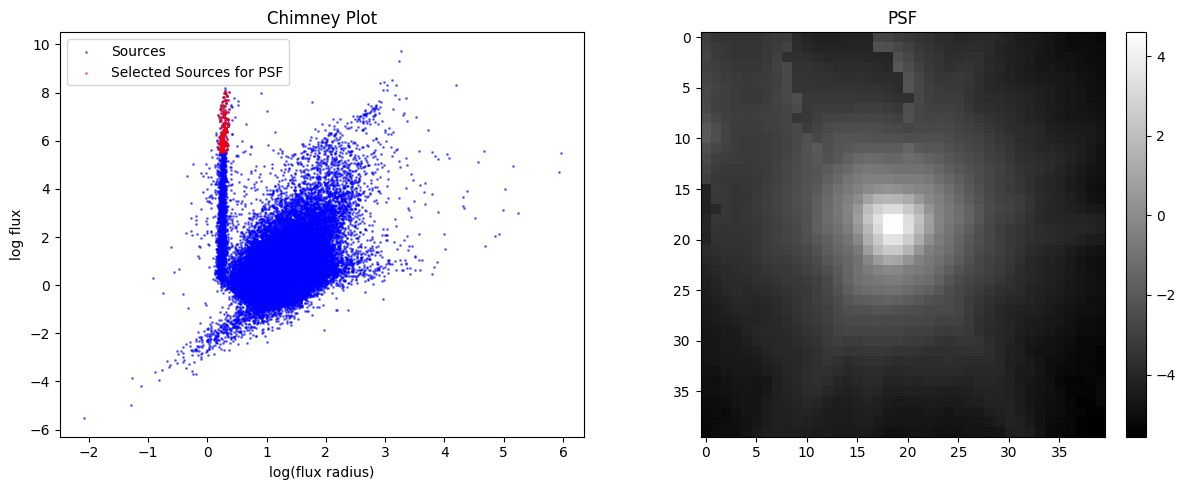

In [193]:
files = glob.glob(f'{location}/{field}/VIS_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file, memmap=True) as hdul:
    hdu = hdul[0]
    image = hdu.data
    wcs = WCS(hdu.header)
    print(hdu.header)
    nx = hdu.header["NAXIS1"]
    ny = hdu.header["NAXIS2"]
pixel_scales = proj_plane_pixel_scales(wcs) * u.deg 
print("Pixel scales:", pixel_scales)
pixel_scales_arcsec = pixel_scales.to(u.arcsec)
pixel_scale_euclid = pixel_scales_arcsec.mean().value
print("Mean pixel scale (arcsec/pixel):", pixel_scale_euclid)
x_c, y_c = wcs.wcs_world2pix(ra_reference, dec_reference, 0, ra_dec_order=True)
catalog = Table.read(f'{location}/{field}/VIS.cat', format="fits", hdu=2)
psf = create_psf(image, catalog, 40, plot_chimney=True, plot_psf=True, window_size=0.05, lower_percentile=90)

In [8]:
original_sizes = np.linspace(2, 30, 30)
size = 64
psf_cache = prepare_wiener_psf(psf, [size, size], K=0)
weight_sigmas = np.full(len(original_sizes), np.nan)
for i,original_size in enumerate(original_sizes):
    weight = gaussian_weight(size, size, size / 2, size / 2, original_size)
    weight_rescale = wiener_deconvolution_fast(weight, psf_cache)
    y = np.arange(weight_rescale.shape[0])
    x = np.arange(weight_rescale.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten image and coordinates
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = weight_rescale.ravel()

    amplitude_guess = np.max(weight_rescale)
    x0_guess = np.argmax(np.sum(weight_rescale, axis=0))
    y0_guess = np.argmax(np.sum(weight_rescale, axis=1))
    sigma_guess = original_size

    initial_guess = [amplitude_guess, sigma_guess, x0_guess, y0_guess]

    popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)
    amplitude, weight_sigma, x0, y0 = popt
    weight_sigmas[i] = weight_sigma

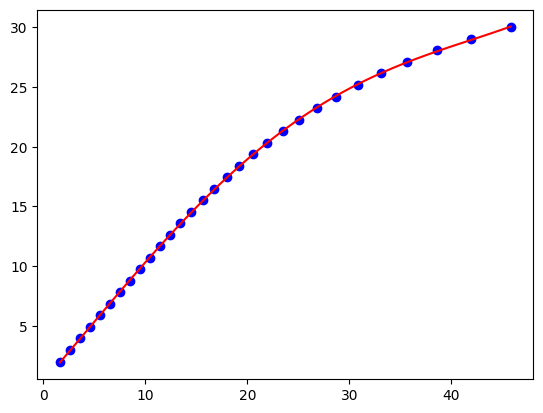

In [9]:
n = 4
coeffs = np.polyfit(np.abs(weight_sigmas[~np.isnan(weight_sigmas)]), original_sizes[~np.isnan(weight_sigmas)], n)
f = Polynomial(coeffs[::-1])  # reverse order

# Evaluate
x_new = np.linspace(np.nanmin(np.abs(weight_sigmas)), np.nanmax(np.abs(weight_sigmas)), 100)
y_fit = f(x_new)
plt.scatter(np.abs(weight_sigmas), original_sizes, color='blue')
plt.plot(x_new, y_fit, color='red')
plt.show()

In [10]:
amplitude_guess = np.mean(image[:3400, :3400])
sigma_guess = 2
initial_guess = [amplitude_guess, sigma_guess]

In [11]:
size = 64
aperture_size = np.full(len(x_c), np.nan)
for i, (x_center, y_center) in enumerate(zip(x_c, y_c)):
    x0 = int(round(x_center))
    y0 = int(round(y_center))

    # bounds (clip to image)
    x_min = max(0, x0 - size//2)
    x_max = min(nx, x0 + size//2 + 1)
    y_min = max(0, y0 - size//2)
    y_max = min(ny, y0 + size//2 + 1)

    cutout = image[y_min:y_max, x_min:x_max]

    x_center_cutout = x_center - x_min
    y_center_cutout = y_center - y_min

    # local coordinate grid
    y, x = np.mgrid[y_min:y_max, x_min:x_max]
    # plt.imshow(cutout)
    # plt.scatter(x_center_cutout, y_center_cutout, c='r')
    # plt.show()
    # break
    # fit only the cutout
    try:
        popt, _ = curve_fit(
            lambda xy, A, s: gaussian_2d(xy, A, s, x_center, y_center),
            (x, y),
            cutout.ravel(),
            p0=initial_guess
        )
        aperture_size[i] = f(np.abs(popt[1])) * pixel_scale_euclid
        if i % 5000 == 0:
            print(i)
            # plt.imshow(cutout)
            # plt.plot([x_center_cutout, x_center_cutout+np.abs(popt[1])], [y_center_cutout, y_center_cutout+np.abs(popt[1])], c='r')
            # plt.show()
            gc.collect()
    except RuntimeError:
        aperture_size[i] = np.inf

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000


In [12]:
fluxes = {}

fluxes['ra'] = ra_reference
fluxes['dec'] = dec_reference
rubin_filters = ['u', 'g', 'r', 'i', 'z', 'y']
euclid_filters = ['VIS', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
for filter in rubin_filters:
    fluxes[f'flux_{filter}'] = np.full_like(ra_reference, np.nan)
    fluxes[f'flux_{filter}_sigma'] = np.full_like(ra_reference, np.nan)

for filter in euclid_filters:
    fluxes[f'flux_{filter}'] = np.full_like(ra_reference, np.nan)
    fluxes[f'flux_{filter}_sigma'] = np.full_like(ra_reference, np.nan)

In [13]:
def acf(image):
    """
    Compute 2D covariance by FFT of background-subtracted residual.
    - image: 2D array (float)
    - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
    Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
    """
    img = image.astype(float)
    h, w = img.shape
    img -= np.mean(img)

    ac = fftconvolve(img, img[::-1, ::-1], mode="same")

    ac_norm = ac / (h * w)
    return ac_norm / np.max(ac_norm)

def radial_profile(acf):
    y, x = np.indices(acf.shape)
    cy, cx = np.array(acf.shape) // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)

    tbin = np.bincount(r.ravel(), acf.ravel())
    nr = np.bincount(r.ravel())
    return tbin / nr

Processing filter: u


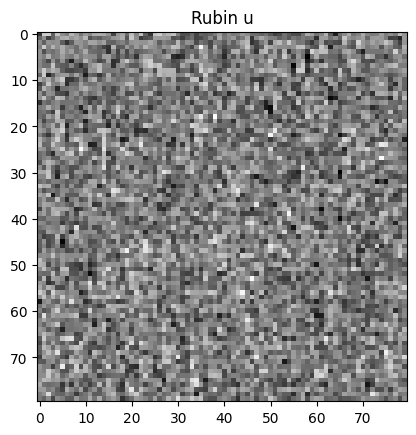

Processing filter: g


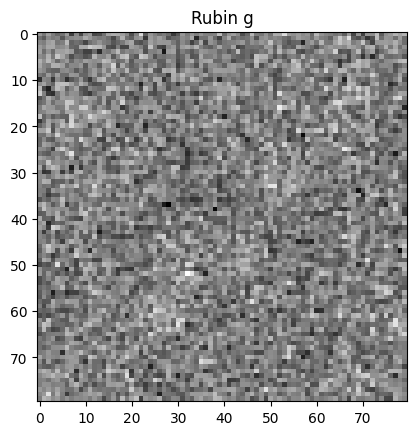

Processing filter: r


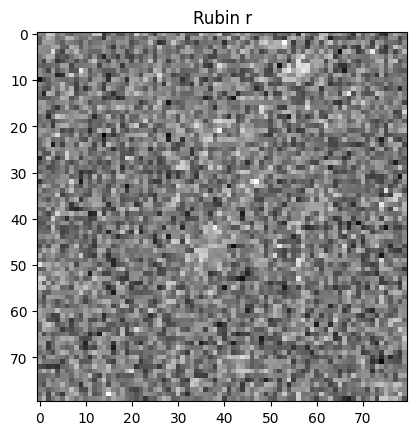

Processing filter: i


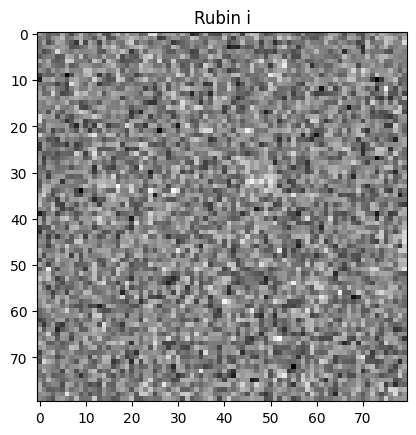

Processing filter: z


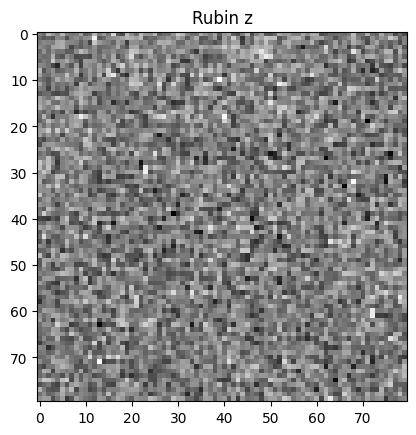

Processing filter: y


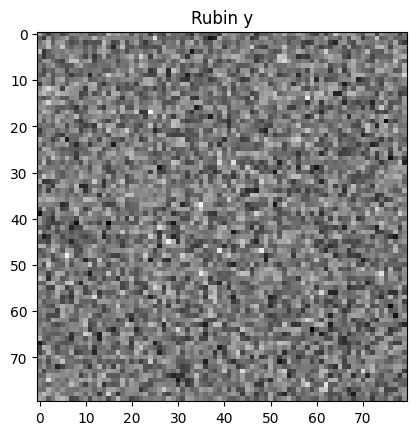

Processing filter: VIS


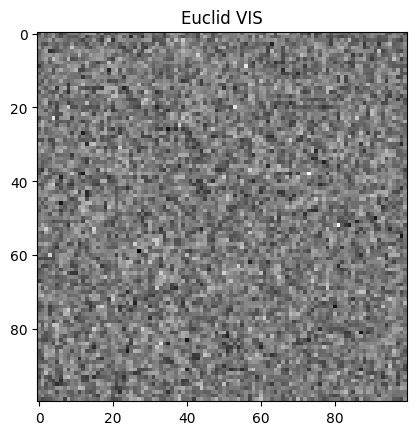

Processing filter: DES-G


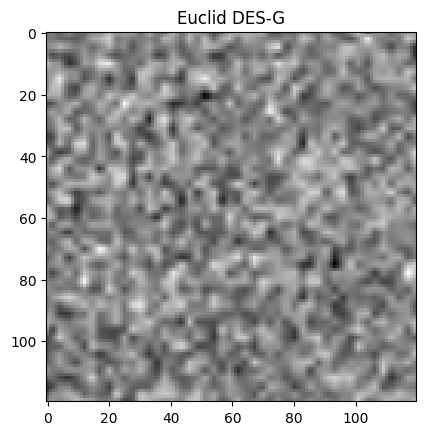

Processing filter: DES-R


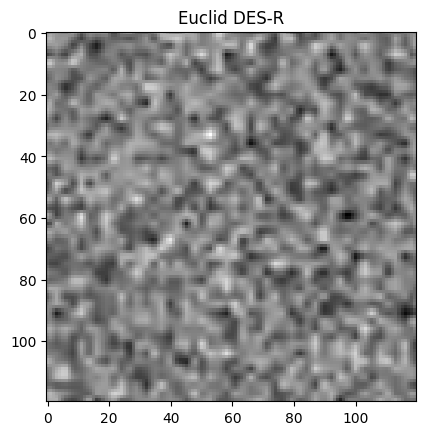

Processing filter: DES-I


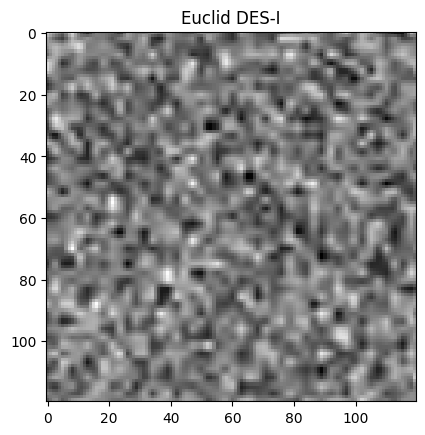

Processing filter: NIR-Y


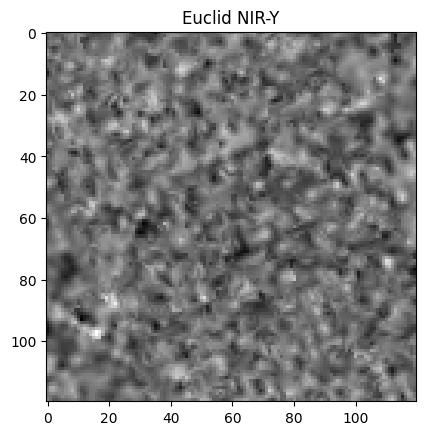

Processing filter: NIR-J


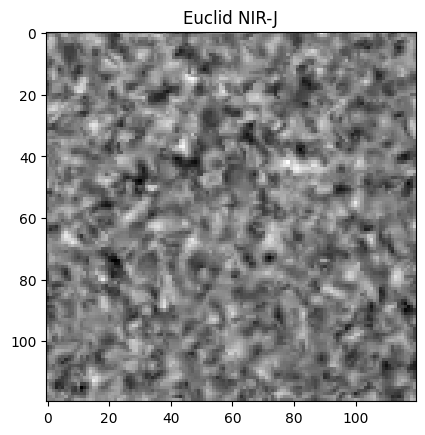

Processing filter: NIR-H


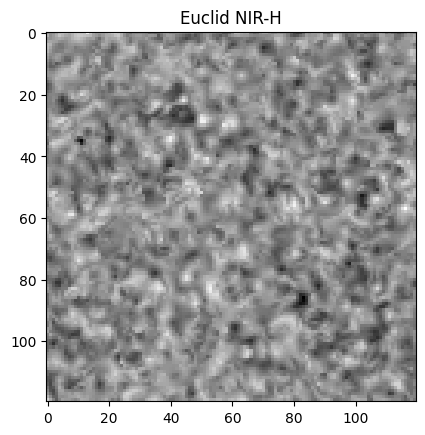

In [14]:
covariance_threshold = 0.01
noise_squares = {}
maxlag = {}

for filter in rubin_filters:
    print(f'Processing filter: {filter}')
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [f for f in files if not f.endswith("psf.fits")][0]

    with fits.open(image_file, memmap=True) as hdul:
        hdu = hdul[1]
        image = hdu.data

    noise_cutout = find_noise_square(image, 80)
    plt.imshow(noise_cutout, cmap='gray')
    plt.title(f'Rubin {filter}')
    plt.show()
    noise_squares[filter] = noise_cutout
    covariance = acf(noise_cutout)
    covariance_r = radial_profile(covariance)
    r_corr = np.where(np.abs(covariance_r) < covariance_threshold)[0][0]
    maxlag[filter] = r_corr
    gc.collect()


for filter in euclid_filters:
    print(f'Processing filter: {filter}')
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [f for f in files if not f.endswith("psf.fits")][0]

    with fits.open(image_file, memmap=True) as hdul:
        hdu = hdul[0]
        image = hdu.data
        zeropoint = hdu.header["MAGZERO"]
        conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 10**9

    if filter == 'VIS':
        noise_cutout = find_noise_square(image[:4000, :4000], 100) * conversion_factor
    
    else:
        noise_cutout = find_noise_square(image[:4000, :4000], 120) * conversion_factor
    plt.imshow(noise_cutout, cmap='gray')
    plt.title(f'Euclid {filter}')
    plt.show()
    noise_squares[filter] = noise_cutout
    covariance = acf(noise_cutout)
    covariance_r = radial_profile(covariance)
    r_corr = np.where(np.abs(covariance_r) < covariance_threshold)[0][0]
    maxlag[filter] = r_corr
    gc.collect()

In [15]:
print(maxlag)

{'u': np.int64(2), 'g': np.int64(6), 'r': np.int64(5), 'i': np.int64(2), 'z': np.int64(4), 'y': np.int64(3), 'VIS': np.int64(2), 'DES-G': np.int64(5), 'DES-R': np.int64(5), 'DES-I': np.int64(5), 'NIR-Y': np.int64(6), 'NIR-J': np.int64(5), 'NIR-H': np.int64(11)}


Processing filter: u


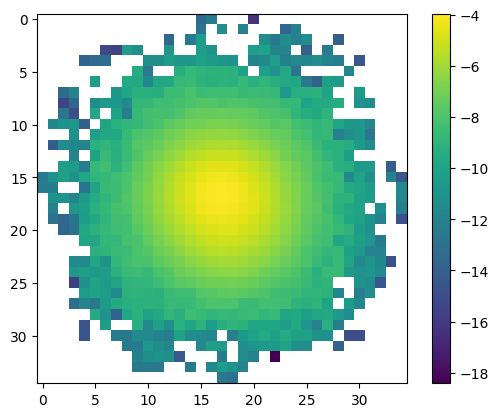

Processing filter: g


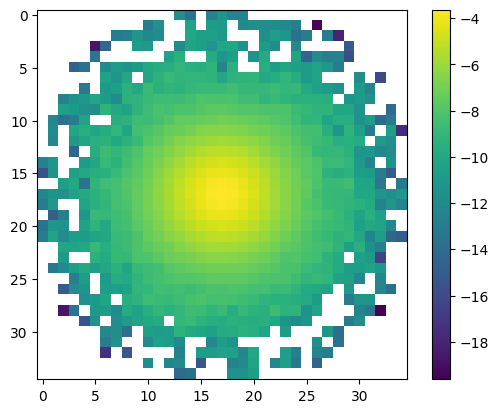

Processing filter: r


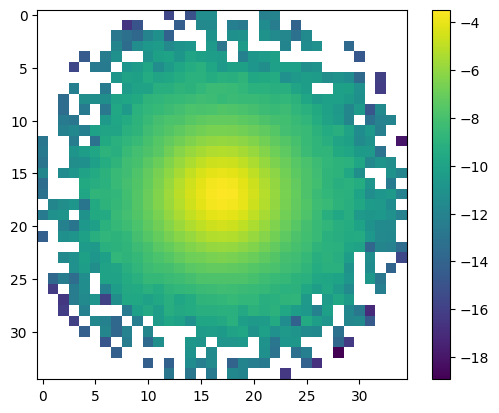

Processing filter: i


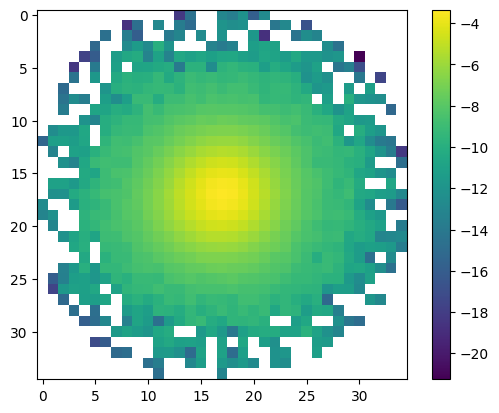

Processing filter: z


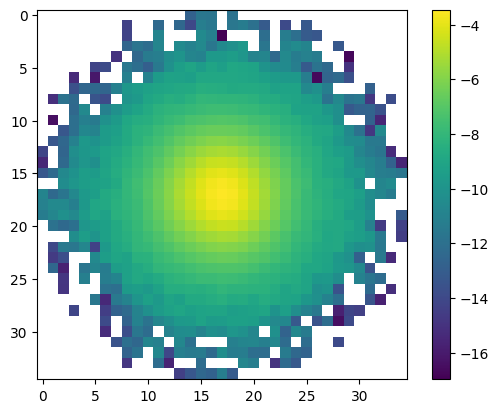

Processing filter: y


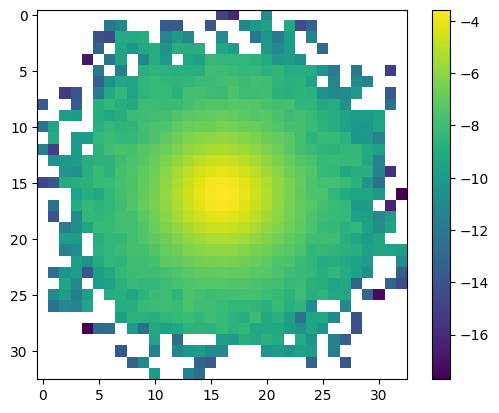

Processing filter: VIS


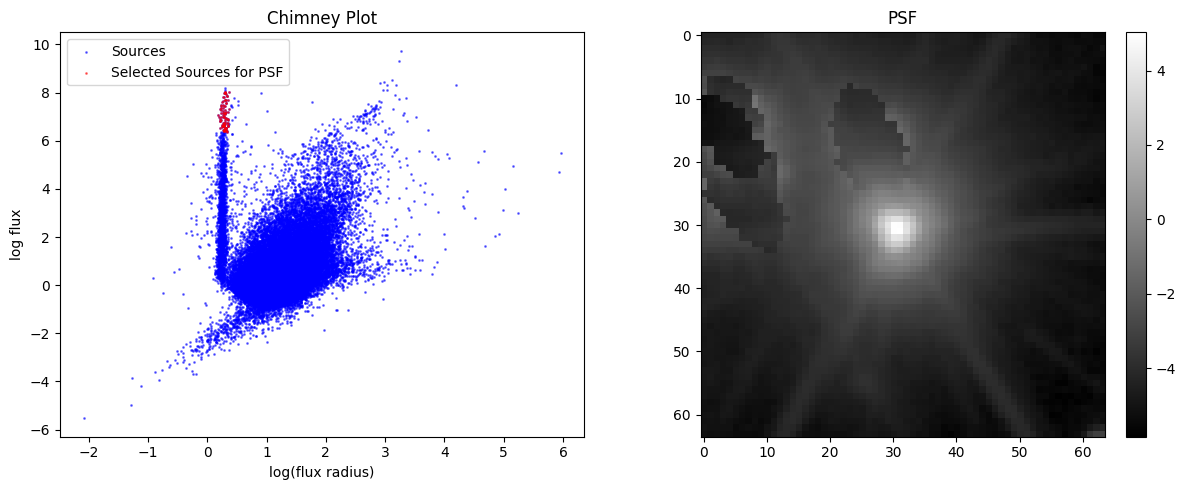

Processing filter: DES-G


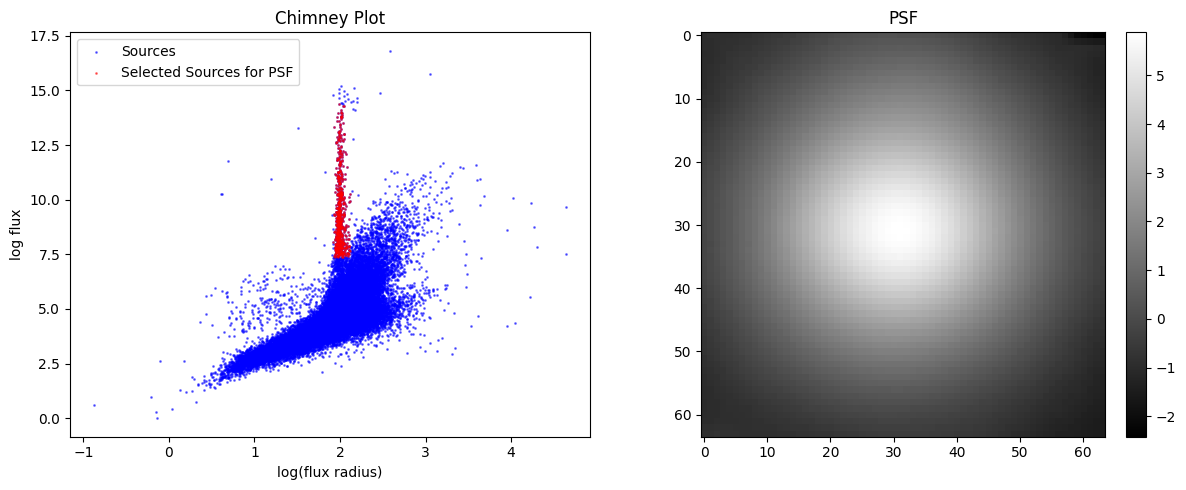

Processing filter: DES-R


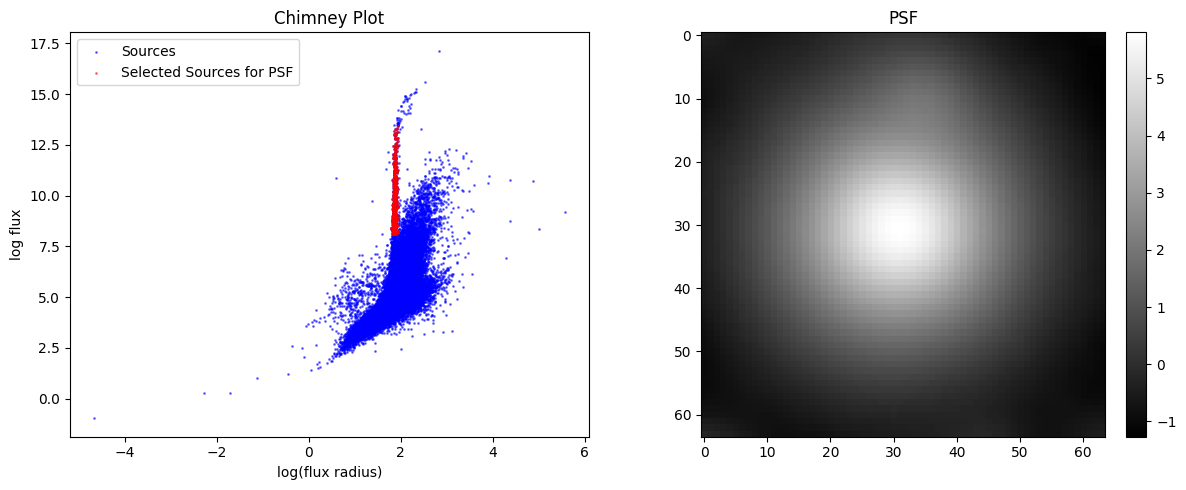

Processing filter: DES-I


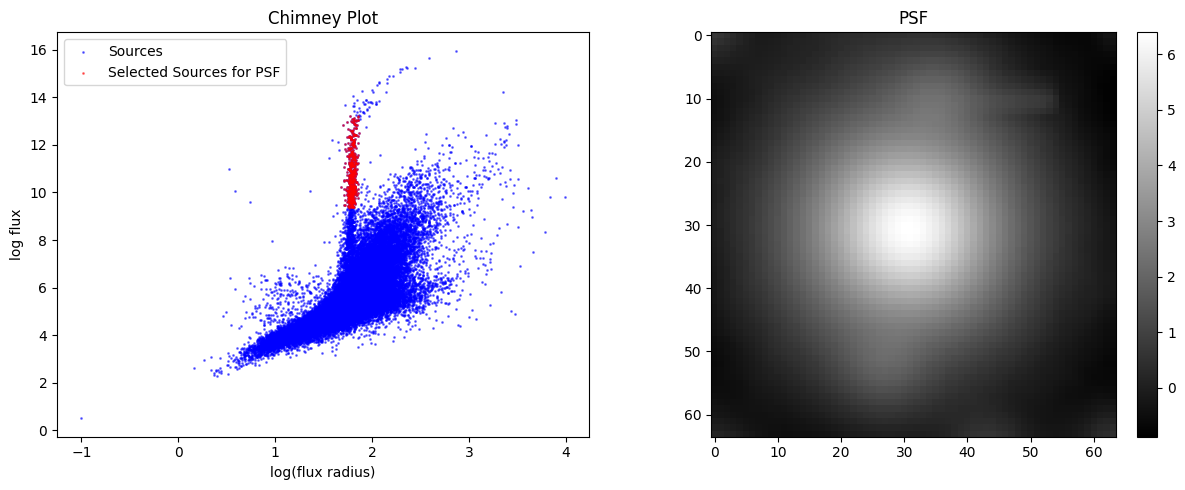

Processing filter: NIR-Y


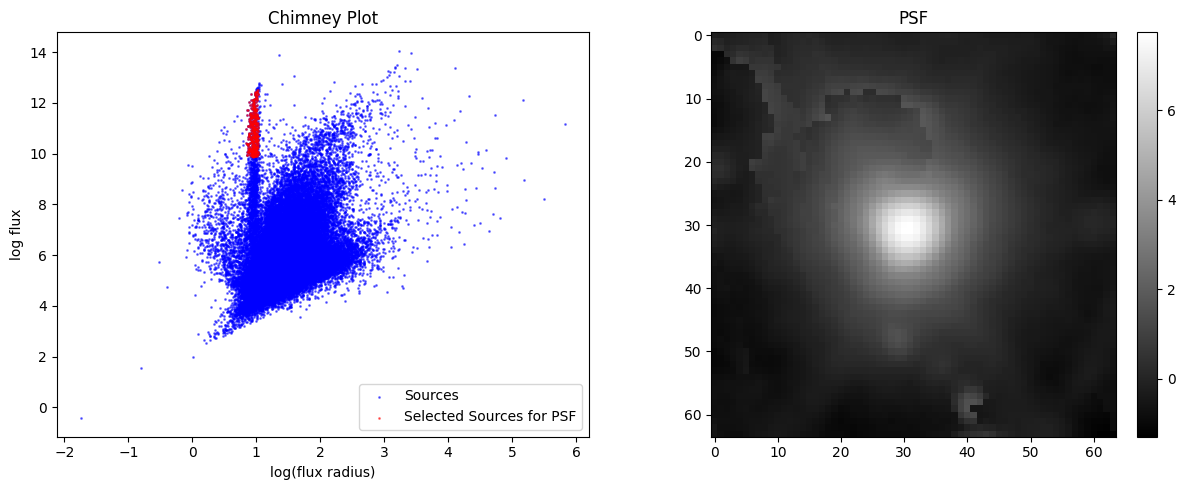

Processing filter: NIR-J


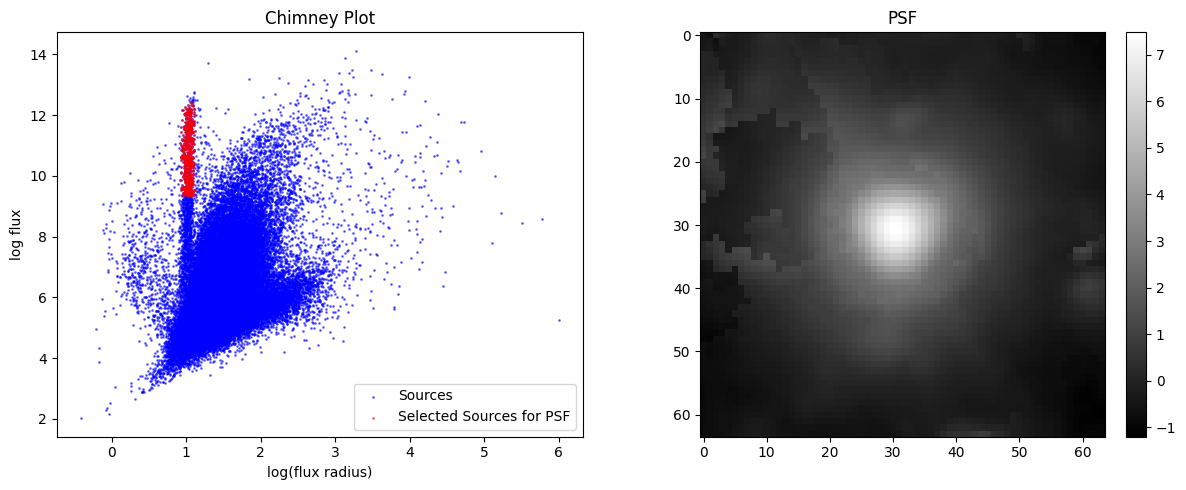

Processing filter: NIR-H


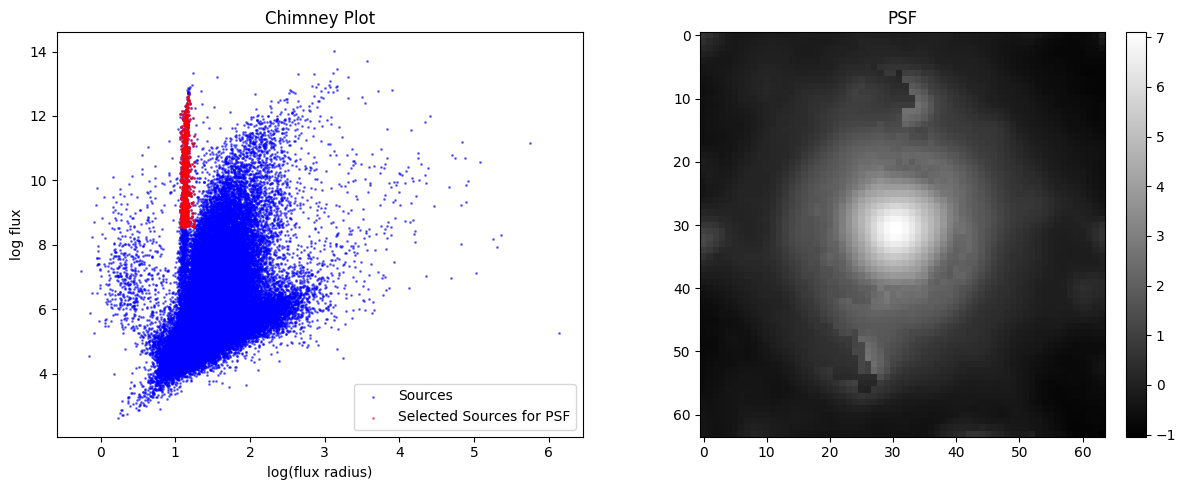

In [199]:
psfs = {}
psf_sizes = {}
for filter in rubin_filters:
    print(f'Processing filter: {filter}')
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    psf_file = [f for f in files if f.endswith("psf.fits")][0]
    with fits.open(psf_file) as hdul:
        psf = hdul[0].data
    psfs[filter] = psf
    plt.imshow(np.log(psf))
    plt.colorbar()
    plt.show()

    y, x = np.mgrid[0:psf.shape[0], 0:psf.shape[0]]
    initial_guess = [np.max(psf), 4]
    popt, _ = curve_fit(
        lambda xy, A, s: gaussian_2d(xy, A, s, psf.shape[0] * 0.5, psf.shape[0] * 0.5),
        (x, y),
        psf.ravel(),
        p0=initial_guess
    )
    psf_sizes[filter] = np.abs(popt[1]) * pixel_scale_rubin


psf_size = 64
for filter in euclid_filters:
    print(f'Processing filter: {filter}')
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [f for f in files if not f.endswith("psf.fits")][0]

    with fits.open(image_file, memmap=True) as hdul:
        hdu = hdul[0]
        image = hdu.data

    catalog = Table.read(f'{location}/{field}/{filter}.cat', format="fits", hdu=2)
    psf = create_psf(image, catalog, psf_size, plot_psf=True, plot_chimney=True, window_size=0.05, lower_percentile=95)
    psfs[filter] = psf
    y, x = np.mgrid[0:psf.shape[0], 0:psf.shape[0]]
    initial_guess = [np.max(psf), 10]
    popt, _ = curve_fit(
        lambda xy, A, s: gaussian_2d(xy, A, s, psf.shape[0] * 0.5, psf.shape[0] * 0.5),
        (x, y),
        psf.ravel(),
        p0=initial_guess
    )
    psf_sizes[filter] = np.abs(popt[1]) * pixel_scale_euclid
    gc.collect()

In [17]:
print(max(psf_sizes.values()))
size = 64
print(size*pixel_scale_rubin/11)

0.6021635762970432
1.1636363636363176


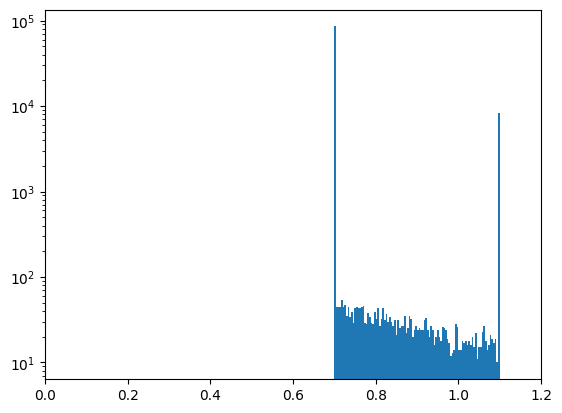

In [18]:
clipped_aperture = np.clip(aperture_size, .7, 1.1)
plt.hist(clipped_aperture, bins=100)
plt.xlim(0, 1.2)
plt.yscale('log')
plt.show()

In [87]:
class GAAP_object:
    def __init__(self, image, psf):
        self.image = image
        self.ny, self.nx = image.shape
        self.psf = psf

        self.noise_square = None
        self.flux = None
        self.variance = None

    def find_noise_square(self, image=None, box_size=50):
        """
        Automatically find a square region with low signal (noise-dominated).
        image: 2D array
        box_size: side of the square region (pixels)
        margin: exclude edges
        threshold: how many sigma above the median to consider as "source"
        returns: (y0, x0, y1, x1) slice indices of best noise square
        """
        if image == None:
            image = self.image

        # smooth absolute value to find low-variance zones
        local_mean = uniform_filter(image, size=box_size)
        local_var = uniform_filter(image**2, size=box_size) - local_mean**2
        local_std = np.sqrt(np.maximum(local_var, 0))

        # exclude borders
        half = box_size // 2
        local_std[:half, :] = np.inf
        local_std[-half:, :] = np.inf
        local_std[:, :half] = np.inf
        local_std[:, -half:] = np.inf

        # pick minimum std region (least structured)
        cy, cx = np.unravel_index(np.nanargmin(local_std), local_std.shape)

        # ensure square fits inside image
        half = box_size // 2
        y0 = max(0, cy - half)
        x0 = max(0, cx - half)
        y1 = min(self.ny, y0 + box_size)
        x1 = min(self.nx, x0 + box_size)

        self.noise_square = image[y0:y1, x0:x1]

    def padded_cutout_with_center(self, image, cx, cy, size):
        """
        Extract a fixed-size cutout centered on (cy, cx).
        Pads with zeros when the cutout extends beyond the image.

        Returns
        -------
        cutout : (size, size) array
        (cy_c, cx_c) : subpixel center in cutout coordinates
        """

        h, w = image.shape
        half = size // 2

        # Integer anchor
        iy = int(np.floor(cy))
        ix = int(np.floor(cx))

        # Desired bounds in image coordinates
        y0 = iy - half
        x0 = ix - half
        y1 = y0 + size
        x1 = x0 + size

        # Overlap with image
        iy0 = max(0, y0)
        ix0 = max(0, x0)
        iy1 = min(self.ny, y1)
        ix1 = min(self.nx, x1)

        # Corresponding region in cutout coordinates
        cy0 = iy0 - y0
        cx0 = ix0 - x0
        cy1 = cy0 + (iy1 - iy0)
        cx1 = cx0 + (ix1 - ix0)

        # Allocate cutout
        cutout = np.zeros((size, size), dtype=image.dtype)

        # Insert image data
        cutout[cy0:cy1, cx0:cx1] = image[iy0:iy1, ix0:ix1]

        # Center in cutout coordinates
        cy_c = cy - y0
        cx_c = cx - x0

        return cutout, (cx_c, cy_c)

    def create_weights(self, sigmas, size):
        y0 = (size - 1) / 2
        x0 = (size - 1) / 2

        y, x = np.mgrid[:size, :size]
        r2 = (x - x0)**2 + (y - y0)**2

        self.weights = np.exp(
            -r2[None, :, :] / (2 * sigmas[:, None, None]**2)
        )

    def prepare_wiener_psf(self, image_shape=[100, 100], K=1e-16, dtype=np.float64):
        """
        Precompute PSF FFT terms for Wiener deconvolution.
        """

        psf = self.psf[::-1, ::-1].astype(dtype, copy=False)

        pad_shape = (
            image_shape[0] + psf.shape[0] - 1,
            image_shape[1] + psf.shape[1] - 1,
        )

        psf_padded = np.zeros(pad_shape, dtype=dtype)
        y0 = pad_shape[0] // 2 - psf.shape[0] // 2
        x0 = pad_shape[1] // 2 - psf.shape[1] // 2
        psf_padded[y0:y0 + psf.shape[0], x0:x0 + psf.shape[1]] = psf

        H = rfft2(ifftshift(psf_padded))
        H_conj = np.conj(H)
        denom = (H * H_conj) + K

        self.psf_cache =  {
            "H_conj": H_conj,
            "denom": denom,
            "pad_shape": pad_shape
    }

    def deconvolve_weights(self):
        W = rfft2(self.weights, self.psf_cache["pad_shape"], axes=(-2, -1))
        F = self.psf_cache["H_conj"][None, :, :] * W / self.psf_cache["denom"][None, :, :]
        result = irfft2(F, self.psf_cache["pad_shape"], axes=(-2, -1))
        self.deconvolved_weight =  result[:, :self.ny, :self.nx]

    def estimate_variance(self, noise_image, weight, maxlag):
        local_covariance = self.covariance_fft2d(noise_image, maxlag)
        variance = self.weighted_variance_lag(weight, local_covariance, maxlag)
        return variance


    def covariance_fft2d(self, image, maxlag):
        """
        Compute 2D covariance by FFT of background-subtracted residual.
        - image: 2D array (float)
        - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
        Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
        """
        img = image.astype(float)
        h, w = img.shape
        img -= np.mean(img)

        ac = fftconvolve(img, img[::-1, ::-1], mode="same")

        ac_norm = ac / (h * w)

        cy, cx = h//2, w//2
        window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
        return window



    def weighted_variance_lag(self, s, C_local, max_lag):
        # Convolution with flipped version of s
        conv = fftconvolve(s, s[::-1, ::-1], mode="full")

        cy, cx = np.array(conv.shape) // 2
        conv_local = conv[
            cy - max_lag : cy + max_lag + 1,
            cx - max_lag : cx + max_lag + 1,
        ]

        return np.sum(conv_local * C_local)

    def calculate_gaap_flux(self, centers, size, noise_square, maxlag):
        self.flux = np.full(centers.shape[1], np.nan)
        self.variance = np.full(centers.shape[1], np.nan)
        x_c, y_c = centers
        mask = (
            (x_c >= 0) & (x_c < self.nx) &
            (y_c >= 0) & (y_c < self.ny)
                )
        mask = np.asarray(mask)

        valid_idx = np.where(mask)[0]
        for i in valid_idx:
            x_center = x_c[i]
            y_center = y_c[i]
            cutout, center = self.padded_cutout_with_center(
            self.image, x_center, y_center, size
            )
            ys = np.array([center[1]])
            xs = np.array([center[0]])
            flux_map = fftconvolve(cutout, self.deconvolved_weight[i, ::-1, ::-1], mode='same')
            self.variance[i] = self.estimate_variance(noise_square, self.deconvolved_weight[i, :, :], maxlag)
            self.flux[i] = map_coordinates(flux_map, [ys, xs], order=1)[0]
        


In [190]:
maxlag

{'u': np.int64(2),
 'g': np.int64(6),
 'r': np.int64(5),
 'i': np.int64(2),
 'z': np.int64(4),
 'y': np.int64(3),
 'VIS': np.int64(2),
 'DES-G': np.int64(5),
 'DES-R': np.int64(5),
 'DES-I': np.int64(5),
 'NIR-Y': np.int64(6),
 'NIR-J': np.int64(5),
 'NIR-H': 7}

In [ ]:
from src.filter_worker import process_filter_2
ctx = get_context("spawn")

tasks = [
    (
        filter,
        location,
        field,
        ra_reference,
        dec_reference,
        size,
        maxlag[filter]*0,
        clipped_aperture / pixel_scale_rubin,
        psfs[filter],
        noise_squares[filter],
        1
    )
    for filter in rubin_filters
]

with ctx.Pool(processes=min(N_cores, len(rubin_filters))) as pool:
    results = pool.map(process_filter_2, tasks)

for filter, flux, sigma in results:
    fluxes[f'flux_{filter}'] = flux / pixel_scale_rubin**2
    fluxes[f'flux_{filter}_sigma'] = sigma / pixel_scale_rubin**2

In [180]:
euclid_size = size*2

ctx = get_context("spawn")

tasks = [
    (
        filter,
        location,
        field,
        ra_reference,
        dec_reference,
        euclid_size,
        maxlag[filter]*0,
        clipped_aperture / pixel_scale_euclid,
        psfs[filter],
        noise_squares[filter],
        0
    )
    for filter in euclid_filters
]

with ctx.Pool(processes=min(N_cores, len(euclid_filters))) as pool:
    results = pool.map(process_filter_2, tasks)

for filter, flux, sigma in results:
    fluxes[f'flux_{filter}'] = flux / pixel_scale_euclid**2
    fluxes[f'flux_{filter}_sigma'] = sigma / pixel_scale_euclid**2

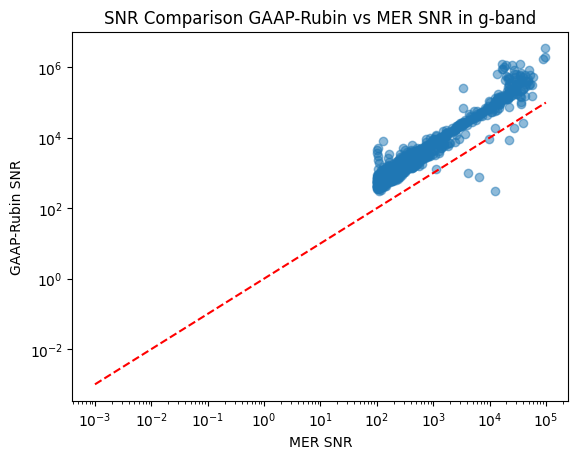

Percent of sources where GAAP-Rubin SNR > MER SNR: 0.9942148760330578
Average SNR improvement factor (GAAP-Rubin / MER): 6.858550103757482


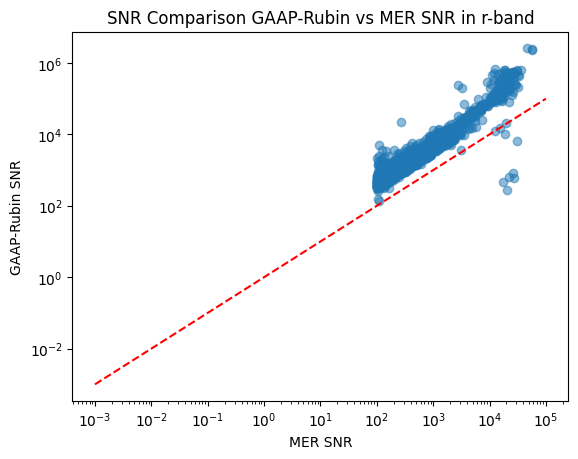

Percent of sources where GAAP-Rubin SNR > MER SNR: 0.995995995995996
Average SNR improvement factor (GAAP-Rubin / MER): 5.942145642188668


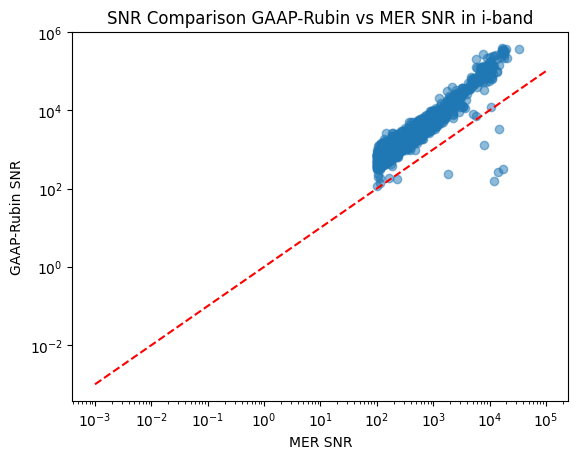

Percent of sources where GAAP-Rubin SNR > MER SNR: 0.99581589958159
Average SNR improvement factor (GAAP-Rubin / MER): 6.397744360243639


In [181]:
for filter in ['g', 'r', 'i']:
    snr_meer = cat[f'FLUX_{filter.upper()}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter.upper()}_EXT_DECAM_4FWHM_APER']
    snr_gaap_rubin = fluxes[f'flux_{filter}']/fluxes[f'flux_{filter}_sigma']
    snr_gaap_rubin = fluxes[f'flux_DES-{filter.upper()}']/fluxes[f'flux_DES-{filter.upper()}_sigma']
    cutoff_snr = 100
    mask = (snr_meer > cutoff_snr) & (snr_gaap_rubin > cutoff_snr) & (np.isfinite(snr_gaap_rubin)) & (np.isfinite(snr_meer))
    plt.scatter(snr_meer[mask],
                snr_gaap_rubin[mask],
                alpha=0.5)
    plt.title(f'SNR Comparison GAAP-Rubin vs MER SNR in {filter}-band')
    plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
    plt.xlabel('MER SNR')
    plt.ylabel('GAAP-Rubin SNR')
    plt.loglog()
    plt.show()
    print("Percent of sources where GAAP-Rubin SNR > MER SNR:", np.nansum(snr_gaap_rubin[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap_rubin[mask])))
    print("Average SNR improvement factor (GAAP-Rubin / MER):", np.nanmean(snr_gaap_rubin[mask] / snr_meer[mask]))

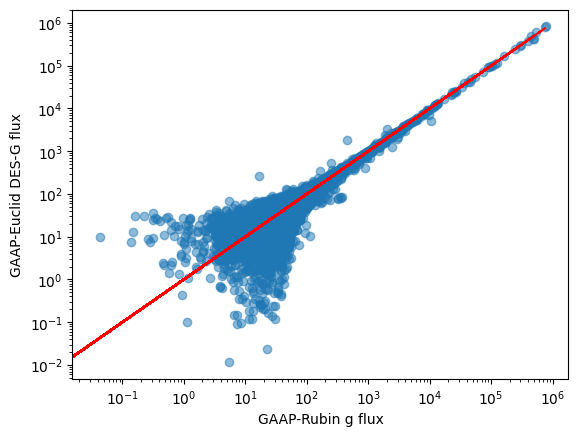

In [184]:
plt.scatter(fluxes['flux_g'], fluxes['flux_DES-G'], alpha=0.5)
plt.plot(fluxes['flux_g'], fluxes['flux_g'], 'r--')
plt.xlabel('GAAP-Rubin g flux')
plt.ylabel('GAAP-Euclid DES-G flux')
plt.loglog()
plt.show()

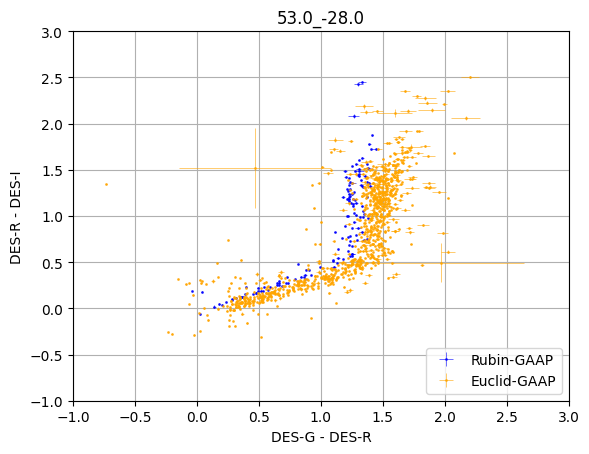

In [191]:
filter_1 = 'flux_g'   # e.g., master_table column name
filter_2 = 'flux_r'
filter_3 = 'flux_r'
filter_4 = 'flux_i'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

# Select star based on MER catalog
mask = cat['POINT_LIKE_PROB'] > 0.9
gaap_error = xerr**2 + yerr**2
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='Rubin-GAAP'
)

filter_1 = 'flux_DES-G'   # e.g., master_table column name
filter_2 = 'flux_DES-R'
filter_3 = 'flux_DES-R'
filter_4 = 'flux_DES-I'

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

gaap_error = xerr**2 + yerr**2
# Select star based on MER catalog
mask = cat['POINT_LIKE_PROB'] > 0.9
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='Euclid-GAAP'
)

plt.title(f'{field}')
plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.grid(True)
plt.legend()
plt.show()

In [72]:
df = pd.DataFrame(fluxes)

In [76]:
df.to_csv(f'/net/vdesk/data2/deklerk/GAAP_data/{field}/fluxes.csv', index=False)